# Plot face grid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from facer import facer
import cv2
import os

Loading face detector and landmark prediction models...
Done, models loaded.


In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def load_images(root, extensions=["png"], verbose=True):
    """Returns list of image arrays"""
    files = sorted(facer.glob_image_files(root, extensions))
    num_files = len(files)
    if verbose:
        print(f"\nFound {num_files} in '{root}'.")
        N = max(round(0.10 * num_files), 1)

    # Load the images
    images = {}
    for n, file in enumerate(files):
        if verbose and n % N == 0:
            print(f"({n + 1} / {num_files}): {file}")

        image = cv2.imread(file)[..., ::-1]
        image = np.float32(image) / 255.0
        images[file] = image
    return images

# Make a GIF

In [5]:
from matplotlib import animation, rc
from IPython.display import HTML, Image
import numpy as np
rc('animation', html='html5')

In [202]:
v = False
path = "./downloads/Top100/39_Target/"
# path = "./downloads/Top100/07_McKesson/"
# path = "./downloads/Top100/03_Apple/"
# path = "./downloads/one-off/VMLY&R/"
images = facer.load_images(path, verbose=v)
landmarks, faces = facer.detect_face_landmarks(images, verbose=v)
averaged, warped, incremental, raw = facer.create_average_face(faces, landmarks, save_image=v, verbose=False)

Done.


In [203]:
def func(**kwargs):
    plt.tight_layout(**kwargs)

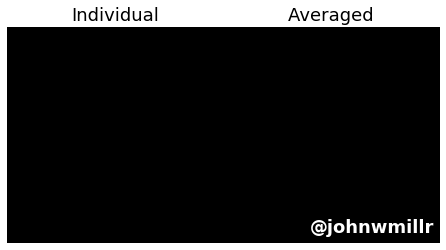

<Figure size 432x288 with 0 Axes>

In [204]:
k = dict(pad=0, w_pad=0, h_pad=0)

fig, axs = plt.subplots(1, 2, figsize=(6, 3.7))
lines = []
titles = ["Individual", "Averaged"]
kwargs = {"fontsize": 18, "color": "white", "alpha": 1.0, "weight": "heavy"}
for ax, title in zip(axs, titles):
    lines.append(ax.imshow(np.zeros_like(warped[0])))
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    if ax == axs[-1]:
        ax.text(585, 570, "@johnwmillr", **kwargs, ha='right')
func(**k)
plt.show()

# initialization function: plot the background of each frame
def init():
    for line in lines:
        line.set_data(np.zeros_like(raw[0]))
    func(**k)
    return lines

# animation function. This is called sequentially
def animate(i):
    num_raw = len(raw)
    i = min(num_raw - 1, i)
    orig, average = lines
    orig.set_data(raw[i])
    average.set_data(incremental[-num_raw:][i])
    func(**k)
    return lines

# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=round(1.5 * len(raw)), interval=500, blit=True)
anim

In [205]:
fps = (1e3 / anim._interval)
fn = path.rstrip("/").rsplit("/", 1)[-1]
print(fn)
anim.save(f'./gifs/{fn}.gif', writer='imagemagick', fps=fps)
print("Done saving the GIF.")

39_Target


<Figure size 432x288 with 0 Axes>

## Plot the individual grids

In [65]:
path_to_faces = "./subset"
faces = load_images(path_to_faces, ["jpg"], verbose=False)

In [82]:
ranks, companies = zip(*map(grab_label, list(subset.keys())))

In [194]:
keys, images = zip(*faces.items())

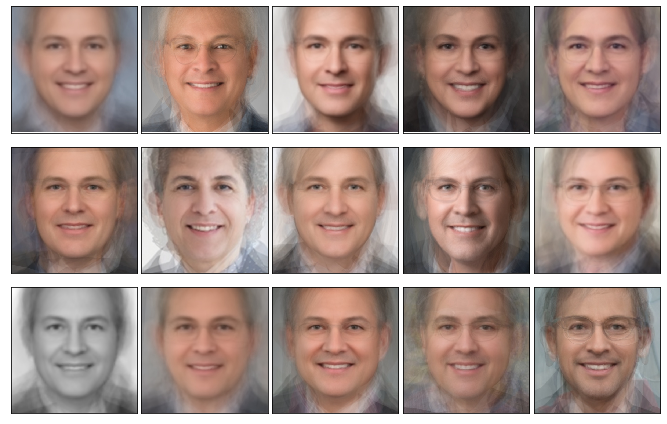

In [220]:
N = 0
num_pics = 15
sub_keys, sub_imgs = keys[N:(N + num_pics)], images[N:(N + num_pics)]
fig, axs = plt.subplots(3, 5, figsize=(11, 6), tight_layout=True)
n = 0
for row in axs:
    for col in row:
        col.set(**{"xticks": [], "yticks": []})
        col.imshow(sub_imgs[n])
        plt.tight_layout(w_pad=-7, h_pad=1)
        
        n += 1
plt.savefig("test.png", dpi=150)
plt.show()

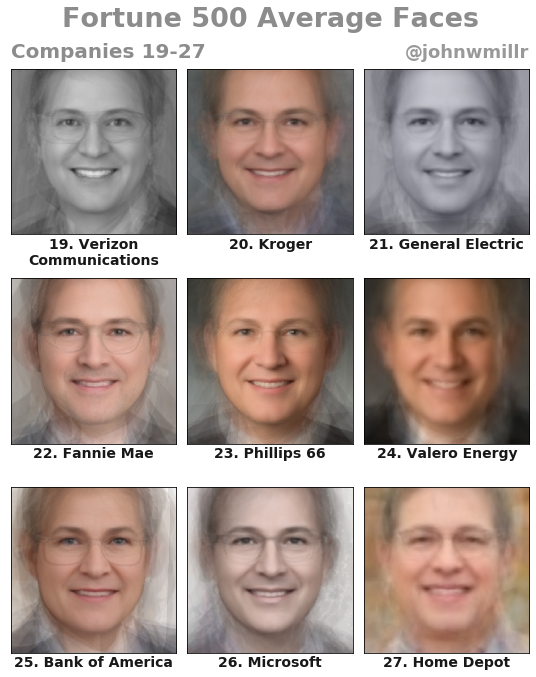

In [183]:
N = 18
subset = {key:val for key, val in zip(list(faces.keys())[N:N + 9], list(faces.items())[N:N + 9])}

grab_label = lambda x: x.replace(path_to_faces, "").split("_", 3)[-2:]
ranks, companies = zip(*map(grab_label, list(subset.keys())))
ranks = list(map(lambda x: x.lstrip("0"), ranks))
companies = map(lambda x: x.replace("_", " ").split(".", 1)[0], companies)
companies = list(map(lambda x: x.replace(" ", '\n', 1) if len(x) > 16 else x, companies))
labels = [(rank, company) for rank, company in zip(ranks, companies)]

kwargs = {"figsize": (10, 9), "sharex": True, "sharey": True}
fig, axs = plt.subplots(nrows=3, ncols=3, **kwargs, tight_layout=True)
plt.tight_layout(h_pad=2.1, w_pad=-7)
keys = list(faces.keys())
n = 0
for row in axs:
    for col in row:
        if n == len(labels):
            continue

        idx = min(n + N, len(keys) - 1)
        image = faces[keys[idx]]
        col.imshow(image)

        kwargs = {"fontsize": 14,  "color": "black", "alpha": 0.9, "weight": "heavy"}
        rank, company = labels[n]
        if company == "AmerisourceBergen":
            company = "Amerisource\nBergen"
        title = f"{rank}. {company}".strip()
        col.text(300, 610, title, **kwargs, ha="center", va="top")
#         col.set_xlabel(title, **kwargs)
        col.set(**{"xticks": [], "yticks": []})
        plt.tight_layout(h_pad=2.1, w_pad=-6)
        
        if n == 2 and col == row[-1]:
            kwargs = {"color": "gray", "alpha": 0.8, "weight": "heavy", "fontsize": 18}
            col.text(600, -40, "@johnwmillr", **kwargs, ha='right', )
        if n == 0:
            txt = f"Companies {N + 1}-{min(N + 9, len(keys))}"
            kwargs = {"color": "gray", "alpha": 0.9, "weight": "heavy", "fontsize": 20}
            col.text(0, -40, txt, **kwargs, ha="left")
        n += 1
plt.tight_layout(h_pad=2.1, w_pad=-7)
title = f"Fortune 500 Average Faces\n"
kwargs = {"fontsize": 27, "color": "gray", "alpha": 0.9, "weight": "heavy"}
plt.suptitle(title, y=1.04, **kwargs)
#     fn = title.replace(" ", "_").replace("\n", "_").lower() + ".png"
#     fig.savefig(fn, dpi=300, bbox_inches="tight")
plt.show()

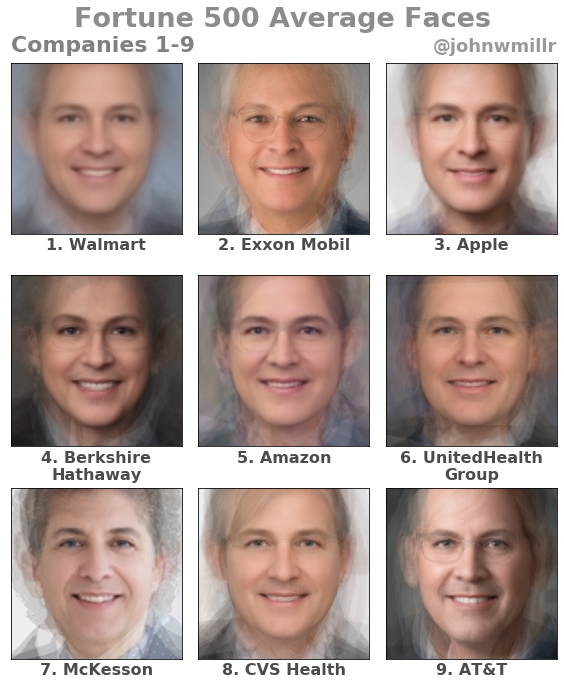

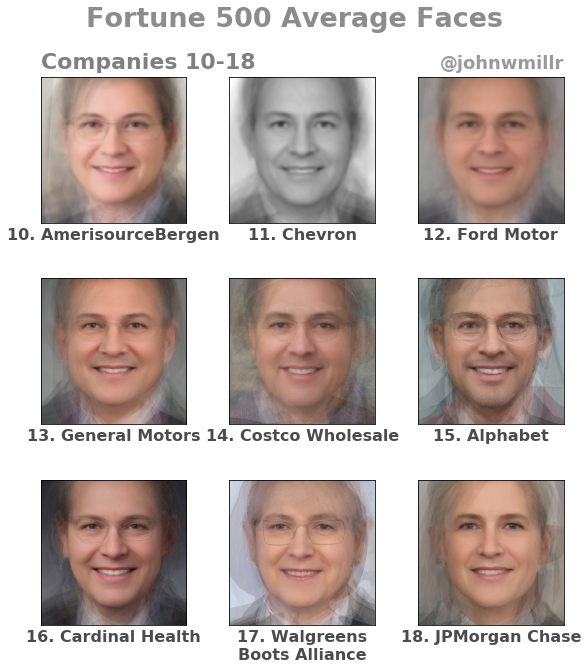

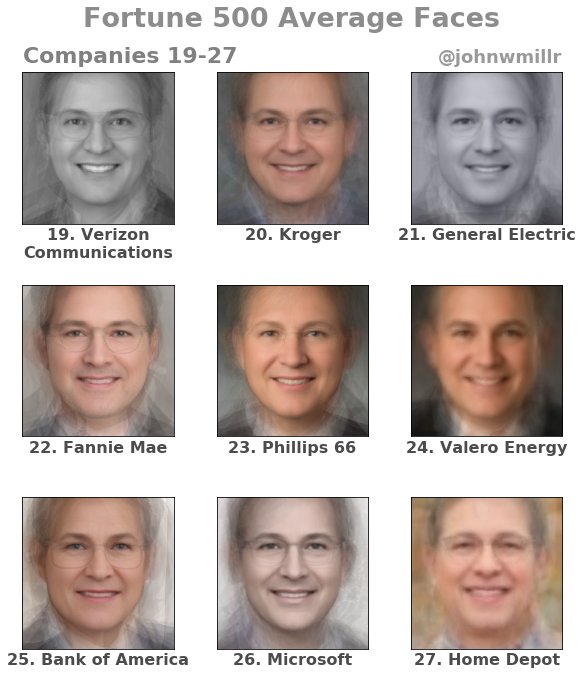

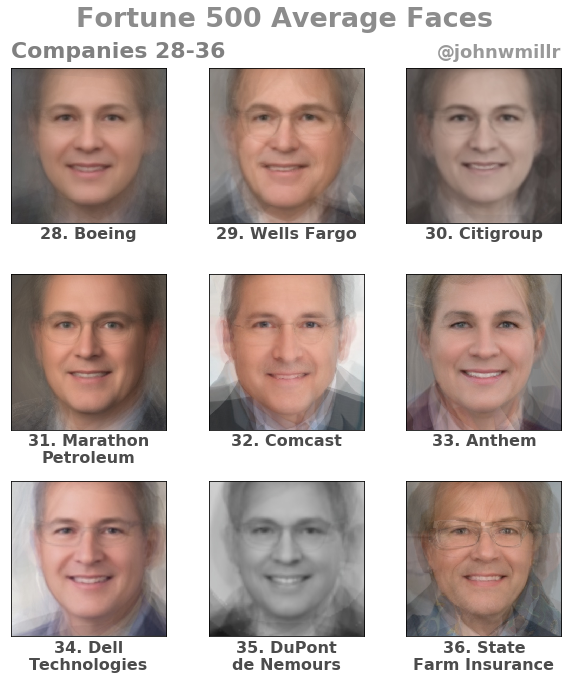

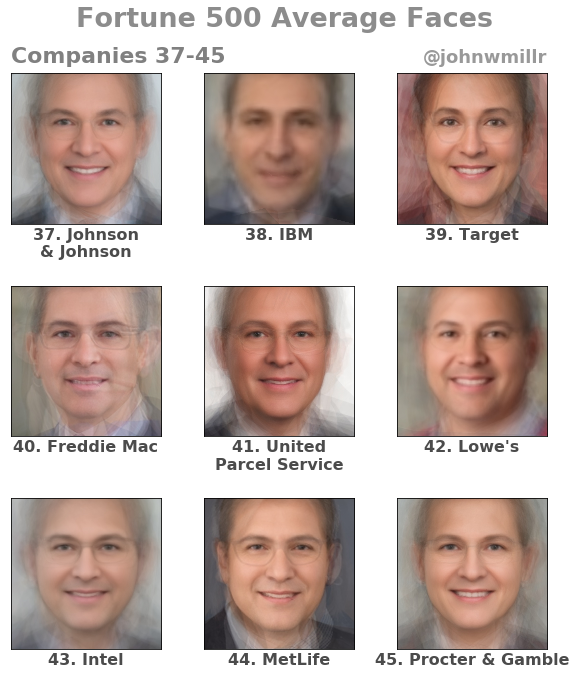

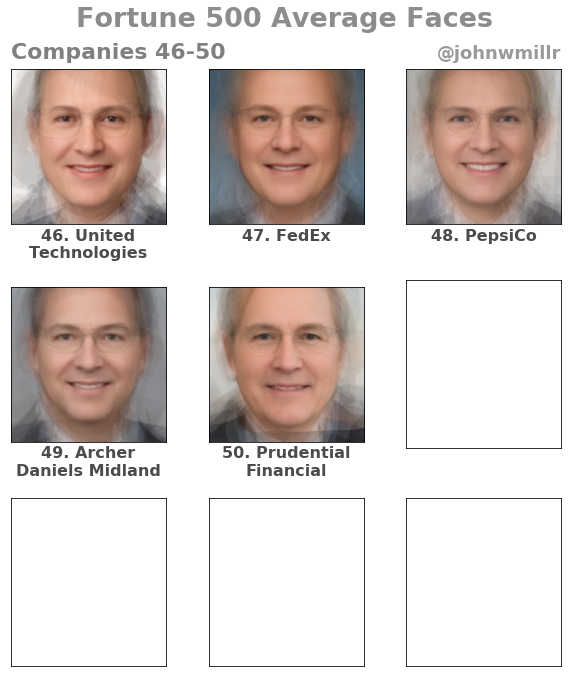

In [121]:
for N in range(0, len(faces), 9):
    subset = {key:val for key, val in zip(list(faces.keys())[N:N + 9], list(faces.items())[N:N + 9])}

    grab_label = lambda x: x.replace(path_to_faces, "").split("_", 3)[-2:]
    ranks, companies = zip(*map(grab_label, list(subset.keys())))
    ranks = list(map(lambda x: x.lstrip("0"), ranks))
    companies = map(lambda x: x.replace("_", " ").split(".", 1)[0], companies)
    companies = list(map(lambda x: x.replace(" ", '\n', 1) if len(x) > 16 else x, companies))
    labels = [(rank, company) for rank, company in zip(ranks, companies)]

    kwargs = {"figsize": (8, 9), "sharex": True, "sharey": True}
    fig, axs = plt.subplots(nrows=3, ncols=3, **kwargs)
    plt.tight_layout(h_pad=2.1, w_pad=-1)
    keys = list(faces.keys())
    n = 0
    for row in axs:
        for col in row:
            if n == len(labels):
                continue
            
            idx = min(n + N, len(keys) - 1)
            image = faces[keys[idx]]
            col.imshow(image)

            kwargs = {"fontsize": 16,  "color": "black", "alpha": 0.7, "weight": "heavy"}
            rank, company = labels[n]
            title = f"{rank}. {company}"
            col.set_xlabel(title, **kwargs)
            col.set(**{"xticks": [], "yticks": []})
            if n == 2 and col == row[-1]:
                kwargs = {"fontsize": 18, "color": "gray", "alpha": 0.8, "weight": "heavy"}
                col.text(600, -40, "@johnwmillr", **kwargs, ha='right')
            if n == 0:
                txt = f"Companies {N + 1}-{min(N + 9, len(keys))}"
                col.text(0, -40, txt, fontsize=22, color="gray", weight="heavy")
            n += 1
    plt.tight_layout(h_pad=2.1, w_pad=-1)
    title = f"Fortune 500 Average Faces\n"
    kwargs = {"fontsize": 27, "color": "gray", "alpha": 0.9, "weight": "heavy"}
    plt.suptitle(title, y=1.04, **kwargs)
#     fn = title.replace(" ", "_").replace("\n", "_").lower() + ".png"
#     fig.savefig(fn, dpi=300, bbox_inches="tight")
#     plt.show()

# Plot one long grid of faces

10 rows x 5 columns

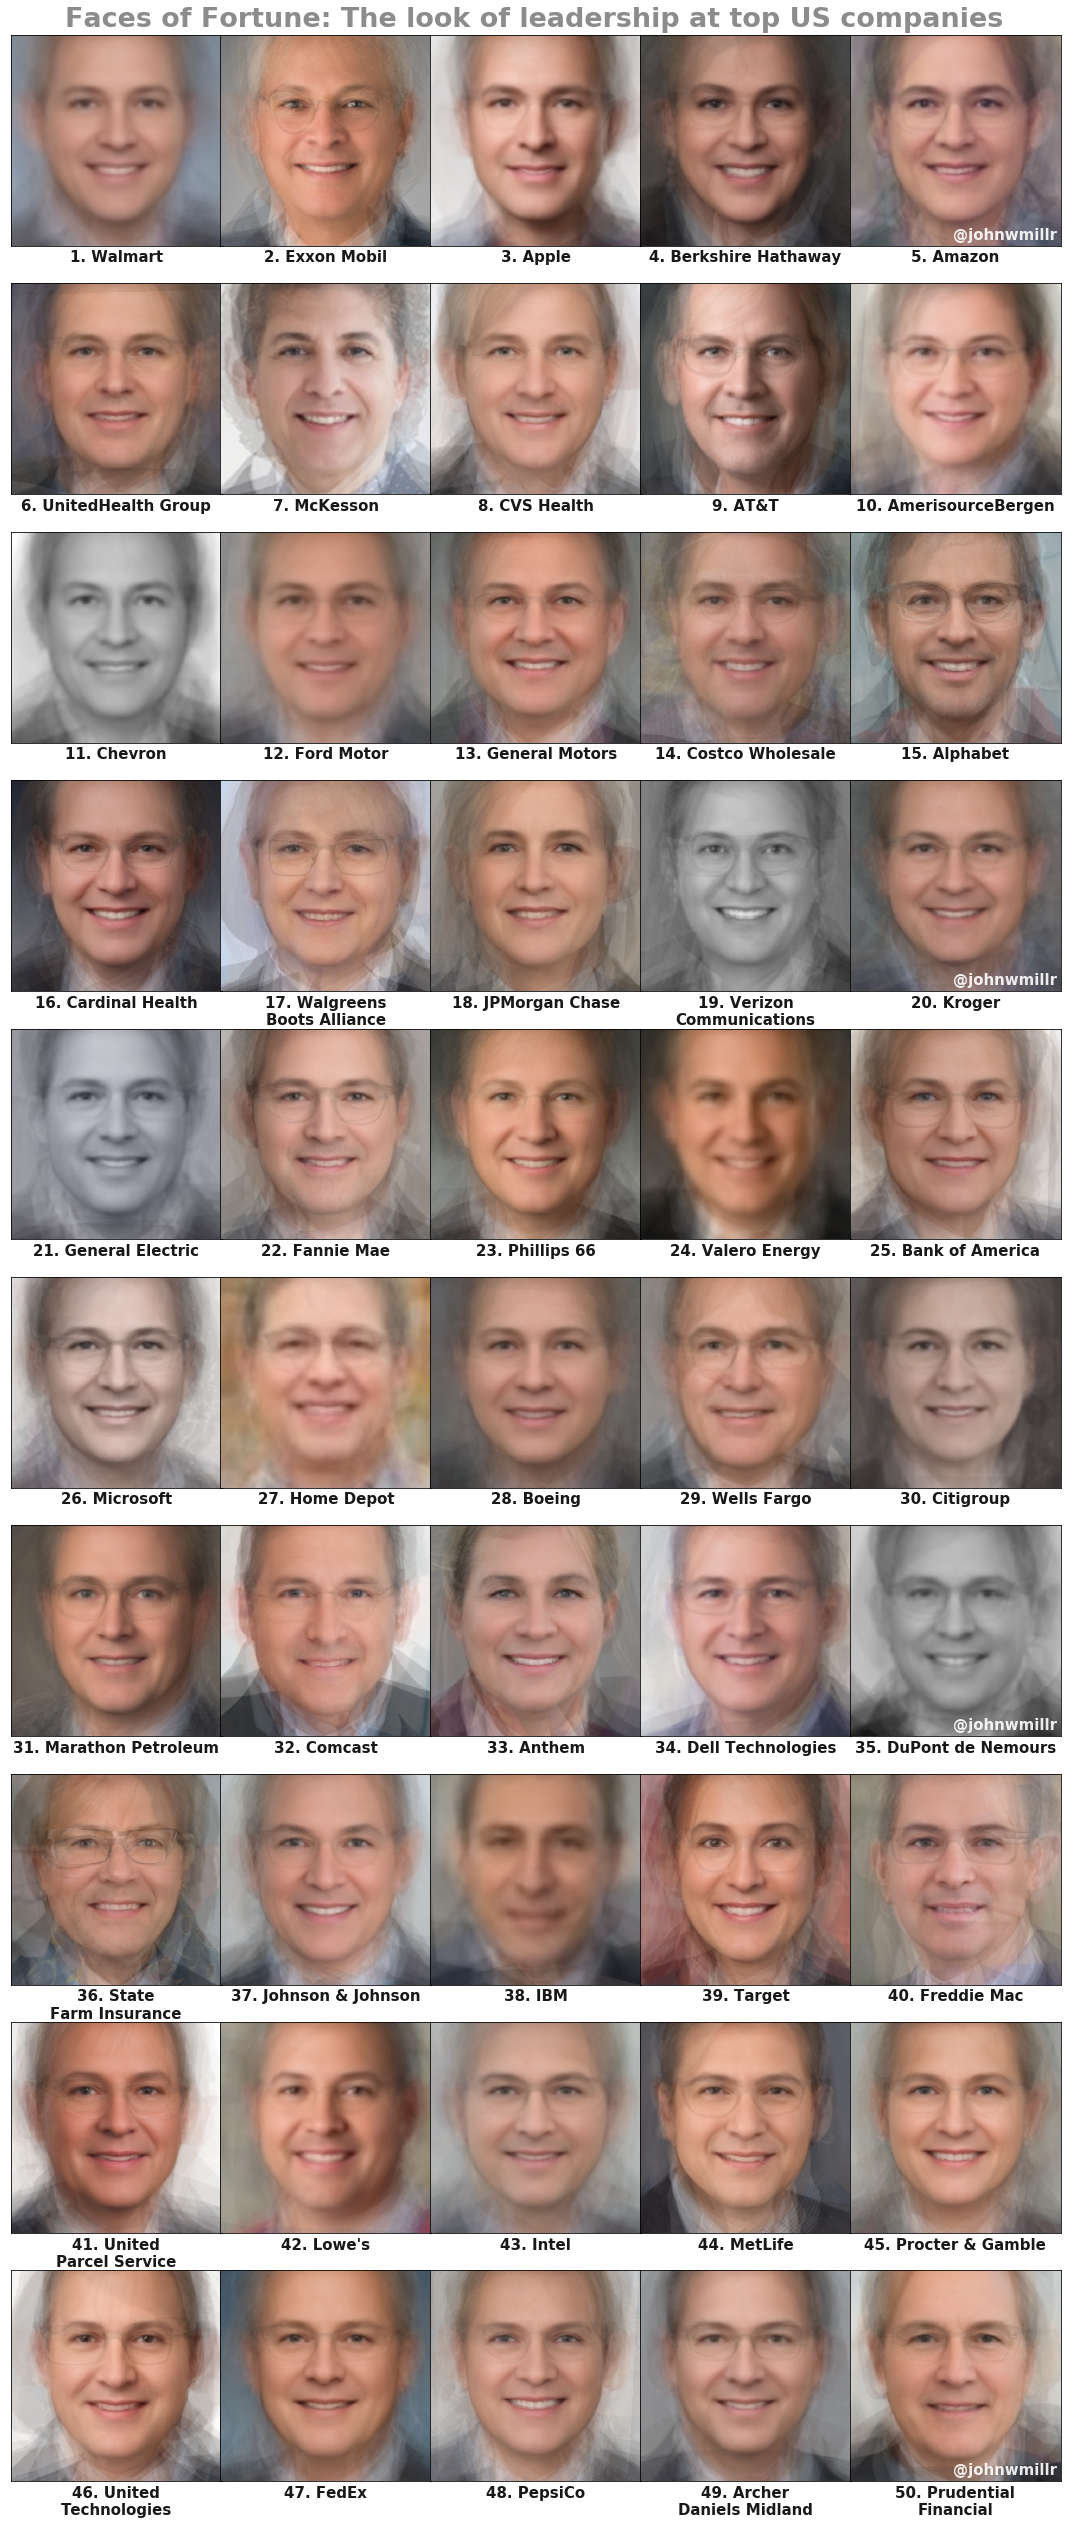

In [234]:
num_cols = 5
subset = {key:val for key, val in zip(list(faces.keys()), list(faces.items()))}

grab_label = lambda x: x.replace(path_to_faces, "").split("_", 3)[-2:]
sub = list(map(grab_label, list(subset.keys())))
labels = [(rank, company.split(".", 1)[0]) for rank, company in sub]
kwargs = {"figsize": (15, 35), "sharex": True, "sharey": True}
fig, axs = plt.subplots(nrows=10, ncols=num_cols, **kwargs)
keys = list(faces.keys())
n = 0
plt.tight_layout(w_pad=-1, h_pad=0.5)
for row in axs:
    for col in row:
        image = faces[keys[n]]
        col.imshow(image)

        kwargs = {"fontsize": 15,  "color": "black", "alpha": 0.9, "weight": "heavy"}
        rank, company = labels[n]
        company = company.replace("_", " ")
        title = company.replace(" ", '\n', 1) if len(company) > 18 else company
        title = f"{rank.lstrip('0')}. {title}"
        x, y = image.shape[:2]

        col.set_xlabel(title, **kwargs)
        col.set(**{"xticks": [], "yticks": []})
        if (n + 1) in [5, 20, 35, 50]:
            kwargs = {"fontsize": 15, "color": "white", "alpha": 0.9, "weight": "heavy"}
            col.text(590, 580, "@johnwmillr", **kwargs, ha='right')
        n += 1

plt.tight_layout(w_pad=-1, h_pad=0.5)
title = "Faces of Fortune: The look of leadership at top US companies"
kwargs = {"fontsize": 27, "color": "gray", "alpha": 0.9, "weight": "heavy"}
plt.suptitle(title, y=1.0, **kwargs)
fn = "Top50_b.png"
fig.savefig(fn, dpi=300, bbox_inches="tight")
plt.show()

## Plot a grid of industry faces

In [5]:
path_to_faces = "./downloads/Industries/average_faces/"
faces = load_images(path_to_faces, ["jpg"], verbose=True)


Found 14 in './downloads/Industries/average_faces/'.
(1 / 14): ./downloads/Industries/average_faces/average_face_Aerospace_&_Defense.jpg
(2 / 14): ./downloads/Industries/average_faces/average_face_Chemicals.jpg
(3 / 14): ./downloads/Industries/average_faces/average_face_Energy.jpg
(4 / 14): ./downloads/Industries/average_faces/average_face_Financials.jpg
(5 / 14): ./downloads/Industries/average_faces/average_face_Food,_Beverages_&_Tobacco.jpg
(6 / 14): ./downloads/Industries/average_faces/average_face_Food_&_Drug_Stores.jpg
(7 / 14): ./downloads/Industries/average_faces/average_face_Health_Care.jpg
(8 / 14): ./downloads/Industries/average_faces/average_face_Household_Products.jpg
(9 / 14): ./downloads/Industries/average_faces/average_face_Industrials.jpg
(10 / 14): ./downloads/Industries/average_faces/average_face_Motor_Vehicles_&_Parts.jpg
(11 / 14): ./downloads/Industries/average_faces/average_face_Retailing.jpg
(12 / 14): ./downloads/Industries/average_faces/average_face_Technology

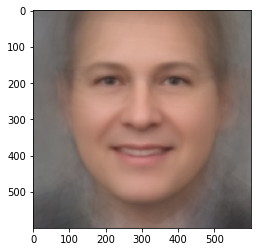

In [10]:
keys = list(faces.keys())
plt.imshow(faces[keys[0]])

In [16]:
keys

['./downloads/Industries/average_faces/average_face_Aerospace_&_Defense.jpg',
 './downloads/Industries/average_faces/average_face_Chemicals.jpg',
 './downloads/Industries/average_faces/average_face_Energy.jpg',
 './downloads/Industries/average_faces/average_face_Financials.jpg',
 './downloads/Industries/average_faces/average_face_Food,_Beverages_&_Tobacco.jpg',
 './downloads/Industries/average_faces/average_face_Food_&_Drug_Stores.jpg',
 './downloads/Industries/average_faces/average_face_Health_Care.jpg',
 './downloads/Industries/average_faces/average_face_Household_Products.jpg',
 './downloads/Industries/average_faces/average_face_Industrials.jpg',
 './downloads/Industries/average_faces/average_face_Motor_Vehicles_&_Parts.jpg',
 './downloads/Industries/average_faces/average_face_Retailing.jpg',
 './downloads/Industries/average_faces/average_face_Technology.jpg',
 './downloads/Industries/average_faces/average_face_Telecommunications.jpg',
 './downloads/Industries/average_faces/average_

In [29]:
keys = list(faces.keys())
grab_label = lambda x: x.split("face_")[-1].rsplit(".")[0].replace("_", " ")
labels = list(map(grab_label, keys))

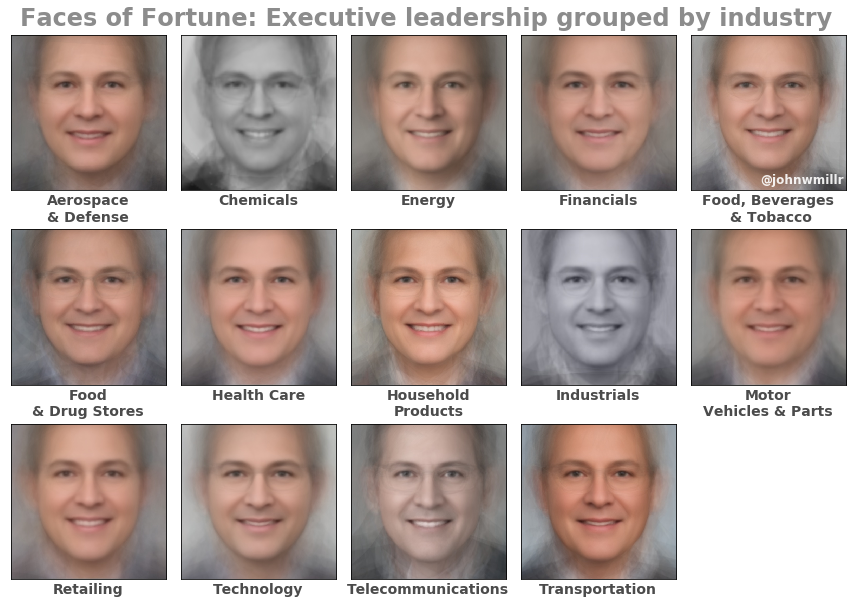

In [53]:
num_cols = 5
kwargs = {"figsize": (12, 8), "sharex": True, "sharey": True}
fig, axs = plt.subplots(nrows=3, ncols=num_cols, **kwargs)
n = 0
plt.tight_layout(w_pad=0.1, h_pad=1.2)
for row in axs:
    for col in row:
        if n >= len(keys):
            col.axis('off')
            break
        image = faces[keys[n]]
        col.imshow(image)

        kwargs = {"fontsize": 14,  "color": "black", "alpha": 0.7, "weight": "heavy"}
        industry = labels[n]
        title = industry.replace(" ", '\n', 1) if len(industry) > 12 else industry
        if n == 4:
            title = "Food, Beverages\n & Tobacco"
        x, y = image.shape[:2]

        col.set_xlabel(title, **kwargs)
        col.set(**{"xticks": [], "yticks": []})
        if col == row[-1] and n == 4:
            kwargs = {"fontsize": 12, "color": "white", "alpha": 0.9, "weight": "heavy"}
            col.text(590, 575, "@johnwmillr", **kwargs, ha='right')
        n += 1
#     break
plt.tight_layout(w_pad=0.1, h_pad=1.2)
title = "Faces of Fortune: Executive leadership grouped by industry"
kwargs = {"fontsize": 24, "color": "gray", "alpha": 0.9, "weight": "heavy"}
plt.suptitle(title, y=1.03, **kwargs)
fn = "Industries.png"
fig.savefig(fn, dpi=300, bbox_inches="tight")
plt.show()